# Generate, Transform and Explore (RGB)

This notebook shows the pipeline for generating synthetic data (RGB images in CSV and COCO format), transforming this data to the TFRecords, and exploring them.

In [1]:
# Let's make sure that JNB can find our SquiDS package ;)
import sys
sys.path.insert(0, '..')

## Generate Synthetic Dataset

### Generate CSV Dataset

In [2]:
from squids import create_dataset
create_dataset(
    image_width=256, image_height=256, random_state=365
)

In [3]:
!ls dataset/synthetic

categories.json  instances_test.csv   instances_val.csv
images		 instances_train.csv


| Artifact            | Type   | Comment |
|---------------------|--------|---------|
| images              | Folder | Contains all generated images |
| instances_train.csv | File   | Contains training records including image and annotations |
| instances_val.csv   | File   | Contains validation records including image and annotations |
| instances_test.csv  | File   | Contains test records including image and annotations |
| categories.json     | File   | Contains information about annotated categories |

As an example let's review the structure of the instances_train.csv file. Please note, the structure of the other two CSV files is the same.

In [4]:
import csv
from tabulate import tabulate

records = []
with open('dataset/synthetic/instances_train.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for record in reader:
        records.append(record)

# reduces the number of records for visualization to 15
records = records[:15]

print(
    tabulate(
        [
            [
                row["image_id"],
                row["file_name"],
                row["bboxes"][:15] + "...",
                row["segmentations"][:15] + "...",
                row["category_ids"]
            ] for row in records
        ],
        headers=[
            "image_id","file_name","bboxes","segmentations","category_ids"
        ],
    )
)

  image_id  file_name    bboxes              segmentations       category_ids
----------  -----------  ------------------  ------------------  --------------
         0  image0.jpg   [[73, 155, 122,...  [[98, 155, 195,...  [2, 3, 1]
         3  image3.jpg   [[44, 154, 82, ...  [[126, 184, 125...  [1, 2]
         4  image4.jpg   [[31, 62, 55, 7...  [[86, 99, 85, 1...  [1, 2]
         5  image5.jpg   [[69, 39, 86, 5...  [[155, 65, 154,...  [1, 3]
         7  image7.jpg   [[59, 69, 78, 6...  [[59, 69, 137, ...  [3]
         8  image8.jpg   [[81, 4, 94, 10...  [[81, 4, 175, 4...  [3]
         9  image9.jpg   [[0, 85, 116, 9...  [[116, 131, 115...  [1, 3, 3]
        10  image10.jpg  [[108, 93, 74, ...  [[162, 93, 182,...  [2]
        13  image13.jpg  [[76, 133, 126,...  [[76, 133, 202,...  [3, 2]
        14  image14.jpg  [[39, 145, 113,...  [[152, 173, 151...  [1, 1]
        15  image15.jpg  [[178, 19, 52, ...  [[206, 19, 230,...  [2, 2]
        16  image16.jpg  [[99, 139, 64, ...  [[139, 1

The `categories.json` file provides more information about each category ID. 

In [5]:
!cat dataset/synthetic/categories.json

{
    "categories": [
        {
            "id": 1,
            "name": "ellipse",
            "supercategory": "shape"
        },
        {
            "id": 2,
            "name": "triangle",
            "supercategory": "shape"
        },
        {
            "id": 3,
            "name": "rectangle",
            "supercategory": "shape"
        }
    ]
}

### Generate COCO Dataset

In [6]:
from squids import create_dataset
create_dataset(
    image_width=256, image_height=256, random_state=365, coco=True
)

In [7]:
!ls dataset/synthetic

annotations  instances_test  instances_train  instances_val


In [8]:
!ls dataset/synthetic/annotations

instances_test.json  instances_train.json  instances_val.json


| Artifact                         | Type   | Comment |
|----------------------------------|--------|---------|
| annotations                      | Folder | Contains files describing annotations |
| annotations/instances_train.json | File   | Contains training records including image and annotations |
| annotations/instances_val.json   | File   | Contains validation records including image and annotations |
| annotations/instances_test.json  | File   | Contains test records including image and annotations |
| instances_train                  | Folder | Contains all generated training images (annotated in instances_train.json) |
| instances_val                    | Folder | Contains all generated validation images (annotated in instances_val.json) |
| instances_test                   | Folder | Contains all generated test images (annotated in instances_test.json) |

As an example let's review the structure of the `instances_train.json` file. Please note, the structure of the other two JSON files is the same.

In [9]:
import json
with open("dataset/synthetic/annotations/instances_train.json") as fp:
    train = json.load(fp)
print("Top sections:", list(train.keys()))


Top sections: ['info', 'licenses', 'images', 'categories', 'annotations']


The top-level of the COCO JSON structure contains the five categories. The following three are the most important for the current topic: `images`, `annotations`, and `categories`. 

Let's review the first record of the `images` property.

In [10]:
print("images[0]:", json.dumps(train["images"][0], indent=4))

images[0]: {
    "file_name": "image0.jpg",
    "coco_url": "file:///dataset/synthetic/instances_train/image0.jpg",
    "width": 256,
    "height": 256,
    "date_captured": "2022-02-15 23:23:15",
    "id": 0
}


It contains information about an image, where the most relevant properties are `file_name` and `id`. The transformer will try to read this image file from the folder derived from the stem name of the JSON file. For example, if this file is `instances_train.json`, the image is expected to be stored in the `../instances_train` folder. So the full path to the image will be `dataset/synthetic/instances_train/image#.jpg`

In [11]:
!ls dataset/synthetic/instances_train/image0.jpg

dataset/synthetic/instances_train/image0.jpg


Let's review the first record of the `annotations` property.

In [12]:
print("annotations[0]:", json.dumps(train["annotations"][0], indent=4))

annotations[0]: {
    "segmentation": [
        [
            98,
            155,
            195,
            199,
            73,
            199
        ]
    ],
    "area": 2684.0,
    "iscrowd": 0,
    "image_id": 0,
    "bbox": [
        73,
        155,
        122,
        44
    ],
    "category_id": 2,
    "id": 0
}


The annotation record contains information about the image it belongs to `image_id`, bounding box coordinates `bbox`, segmentation polygon coordinates `segmentation`, and `category_id` to define what type of an object is segmented. The identifier of the segmentation itself is defined by the `id` property.

Let's review information about available categories. 

In [13]:
print("categories:", json.dumps(train["categories"], indent=4))

categories: [
    {
        "supercategory": "shape",
        "id": 1,
        "name": "ellipse"
    },
    {
        "supercategory": "shape",
        "id": 2,
        "name": "triangle"
    },
    {
        "supercategory": "shape",
        "id": 3,
        "name": "rectangle"
    }
]


## Transform Dataset to TFRecords

This process is the same for the synthetic (or real) dataset in either CSV or COCO formats.

In [14]:
from squids import create_tfrecords
create_tfrecords(image_width=256, image_height=256)

In [15]:

!ls dataset/synthetic-tfrecords
print("\nListing of dataset/synthetic-tfrecords/instances_train:")
!ls dataset/synthetic-tfrecords/instances_train
print("\nListing of dataset/synthetic-tfrecords/instances_val:")
!ls dataset/synthetic-tfrecords/instances_val
print("\nListing of dataset/synthetic-tfrecords/instances_test:")
!ls dataset/synthetic-tfrecords/instances_test

instances_test	instances_train  instances_val

Listing of dataset/synthetic-tfrecords/instances_train:
part-0.tfrecord  part-1.tfrecord  part-2.tfrecord

Listing of dataset/synthetic-tfrecords/instances_val:
part-0.tfrecord

Listing of dataset/synthetic-tfrecords/instances_test:
part-0.tfrecord


## Exploring TFRecords

As a part of the training process, it is important to know that the right data is entering the machine learning model. The following functions allow you to explore data located inside TFRecords.

### Exploring TFRecords using Default Output

In this scenario, the exploring function is using the default mechanism of rendering TFRecords inspection results.

In [16]:
from squids import explore_tfrecords
explore_tfrecords("dataset/synthetic-tfrecords/instances_train")

2022-02-15 23:23:30.277004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 23:23:30.363086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 23:23:30.363512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 23:23:30.367630: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags


dataset/synthetic-tfrecords/instances_train
725 {1}        921 {1}        485 {1, 3}     686 {1, 2}     166 {1}      
726 {2}        922 {1, 2, 3}  486 {3}        687 {1}        167 {3}      
727 {3}        923 {2}        488 {1, 2}     688 {1, 3}     168 {1}      
728 {2, 3}     924 {2}        489 {2, 3}     689 {1, 2}     169 {2}      
729 {1, 2}     925 {3}        490 {2, 3}     690 {1, 3}     172 {1}      
730 {3}        926 {2, 3}     491 {3}        692 {2}        173 {1, 3}   
731 {1, 2}     927 {1}        493 {1, 2}     693 {3}        174 {1, 3}   
733 {2}        929 {1, 3}     494 {3}        694 {2}        175 {2}      
734 {2, 3}     930 {1}        495 {1, 3}     698 {2}        178 {1, 3}   
735 {1, 2}     933 {1}        496 {1, 3}     699 {1, 2, 3}  179 {1, 2, 3}
737 {1, 2, 3}  934 {1, 2, 3}  498 {1}        700 {2, 3}     180 {2}      
739 {2}        935 {3}        499 {1, 3}     702 {2, 3}     181 {3}      
740 {2}        936 {1, 3}     500 {3}        703 {3}        182 {1,

The output shows the total number of records, a list of images IDs combined with annotated categories. For example, the following line`922 {1,2,3}` means that the image with ID `922` has one or more objects of category `1`, one or more objects of category `2`, and one or more objects of category `3` respectively. 

Let's select an image for further exploration.

In [17]:
from squids import explore_tfrecords
explore_tfrecords("dataset/synthetic-tfrecords/instances_train", 0)

Property              Value
--------------------  ----------
image_id              0
image_size            (256, 256)
number_of_objects     3
available_categories  {1, 2, 3}
Image saved to ./0.png


The output contains information about image ID, its size, number of annotated objects, and their categories. Also, all information about bounding boxes, segmentation, and categories are superimposed to an image (in this example `0.png`).

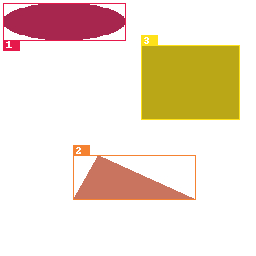

In [18]:
from PIL import Image
img = Image.open("0.png")
img

### Exploring TFRecords Using Custom Output

In this scenario, the exploring function is using a custom mechanism of rendering TFRecords inspection results.

In [19]:
from tabulate import tabulate
from squids import explore_tfrecords
record_ids, record_summaries = explore_tfrecords(
    "dataset/synthetic-tfrecords/instances_train",
    return_artifacts=True
)

# reduces the number of records for visualization to 15
record_ids = record_ids[:15]
record_summaries = record_summaries[:15]

print(
    tabulate(
        [[record_id, record_summary] 
        for record_id, record_summary in zip(record_ids, record_summaries)],
        headers=["Record ID", "Record Summary"],
    )
)

  Record ID  Record Summary
-----------  ---------------------------
        725  Counter({1: 2})
        726  Counter({2: 1})
        727  Counter({3: 2})
        728  Counter({3: 1, 2: 1})
        729  Counter({2: 2, 1: 1})
        730  Counter({3: 2})
        731  Counter({2: 2, 1: 1})
        733  Counter({2: 1})
        734  Counter({3: 2, 2: 1})
        735  Counter({2: 1, 1: 1})
        737  Counter({2: 1, 1: 1, 3: 1})
        739  Counter({2: 2})
        740  Counter({2: 3})
        741  Counter({1: 1, 2: 1})
        743  Counter({2: 1})


{'image_id': 0, 'image_size': (256, 256), 'number_of_objects': 3, 'available_categories': {1, 2, 3}}


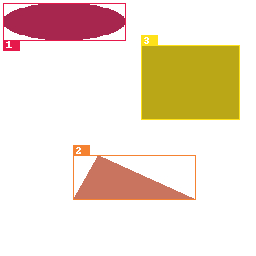

In [20]:
from tabulate import tabulate
from squids import explore_tfrecords
record_image, record_symmary = explore_tfrecords(
    "dataset/synthetic-tfrecords/instances_train", 0,
    return_artifacts=True
)

print(record_symmary)
record_image
